# Sunspot activity prediction
In this notebook, we will use RNNs & LSTMs to predict sunspot activity. This is our first time using raw data

## Utilities

In [321]:
import numpy as np
import tensorflow as tf
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [322]:
def plot_graph(x, y, no_fit=False):
    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'b')

    if no_fit == False:
        fit = linregress(x, y)
        fit_line = fit.slope * x + fit.intercept
        plt.plot(x, fit_line, 'r', linestyle='--')

    plt.ylabel('Graph')
    plt.xlabel('Time')
    plt.grid(True)
    plt.legend(['Graph', 'Fit(Trend)'])
    plt.show()

def multi_plot_graph(x, ys):
    for y in ys:
        plt.plot(x, y)

    plt.grid(True)
    plt.show()

## Dataset download

In [323]:
! pip list | grep kaggle
! pip install kaggle

kaggle                        1.6.3


In [324]:
! kaggle datasets download -d robervalt/sunspots

sunspots.zip: Skipping, found more recently modified local copy (use --force to force download)


In [325]:
# ! unzip sunspots.zip -d sunspot-data/

## Dataset preperation

In [326]:
! head sunspot-data/Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


In [327]:
from csv import reader
time = []
series = []

with open('./sunspot-data/Sunspots.csv', 'r') as csvfile:
    file = reader(csvfile, delimiter=',')
    next(file)

    for row in file:
        time.append(row[0])
        series.append(row[2])

    series = np.array(series, dtype=np.float32)
    time = np.array(time, dtype=np.float32)

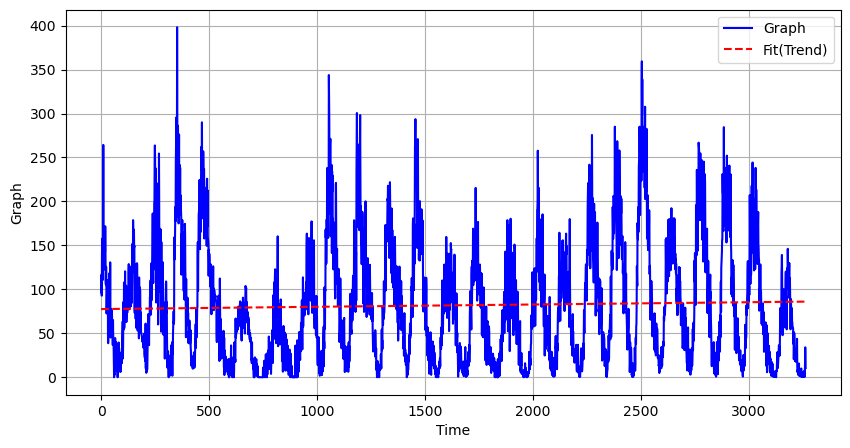

In [328]:
plot_graph(time, series)

In [329]:
print(len(series))

WINDOW_SIZE = 30
BATCH_SIZE = 32
SPLIT_SIZE = 2700

3265


In [330]:
def create_dataset(data, w_size, no_labels=False):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(size=w_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(w_size))

    if no_labels == False:
        dataset = dataset.map(lambda x: (x[:-1], x[-1]))
        dataset = dataset.shuffle(len(data))
    
    dataset = dataset.batch(BATCH_SIZE).prefetch(2)
    return dataset

In [331]:
train_data = series[:SPLIT_SIZE]
train_time = time[:SPLIT_SIZE]
val_data = series[SPLIT_SIZE:]
val_time = time[SPLIT_SIZE:]

print(len(train_data))

2700


In [332]:
train_set = create_dataset(train_data, WINDOW_SIZE + 1)
val_set = create_dataset(val_data, WINDOW_SIZE + 1)

## Model Creation

In [333]:
NUM_FILTERS = 40
KERNEL_SIZE = 5
DENSE_NEURONS = 30
LSTM_UNITS = 20

In [334]:
from tensorflow.keras.layers import Lambda, Conv1D, Dense, Bidirectional, LSTM

def create_model():
    tf.keras.backend.clear_session()
    return tf.keras.Sequential([
        Dense(DENSE_NEURONS, activation='relu', input_shape=(WINDOW_SIZE,)),
        Dense(DENSE_NEURONS // 2, activation='relu'),
        Dense(1)
    ])

In [335]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [336]:
EPOCHS = 500

In [337]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer=SGD(momentum=0.9),
    loss=Huber(),
    metrics=['mae']
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda e: 1e-6 * 10 ** (e / 100))

## Model Training

In [338]:
hist = model.fit(train_set, epochs=EPOCHS, callbacks=[lr_scheduler])

Epoch 1/500


84/84 [==============================] - 0s 647us/step - loss: 36.0174 - mae: 36.5131 - lr: 1.0000e-06
Epoch 2/500
84/84 [==============================] - 0s 392us/step - loss: 28.5199 - mae: 29.0141 - lr: 1.0233e-06
Epoch 3/500
84/84 [==============================] - 0s 396us/step - loss: 26.0246 - mae: 26.5201 - lr: 1.0471e-06
Epoch 4/500
84/84 [==============================] - 0s 395us/step - loss: 24.6890 - mae: 25.1834 - lr: 1.0715e-06
Epoch 5/500
84/84 [==============================] - 0s 375us/step - loss: 23.9150 - mae: 24.4082 - lr: 1.0965e-06
Epoch 6/500
84/84 [==============================] - 0s 402us/step - loss: 23.3775 - mae: 23.8704 - lr: 1.1220e-06
Epoch 7/500
84/84 [==============================] - 0s 393us/step - loss: 22.9461 - mae: 23.4383 - lr: 1.1482e-06
Epoch 8/500
84/84 [==============================] - 0s 404us/step - loss: 22.5725 - mae: 23.0661 - lr: 1.1749e-06
Epoch 9/500
84/84 [==============================] - 0s 406us/step - loss: 22.2926 - mae: 22

## Plotting metrics

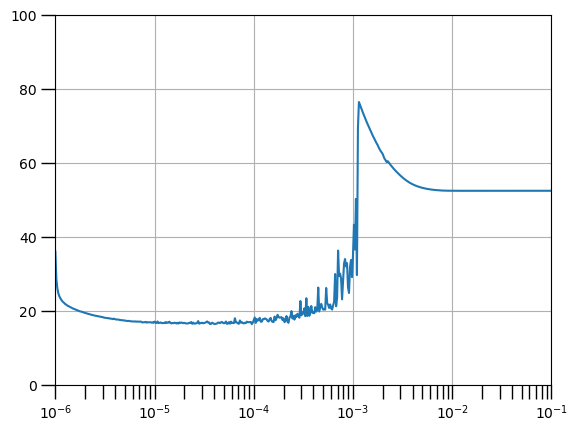

In [339]:
lr_rates = 1e-6 * 10 ** (np.arange(EPOCHS) / 100)
plt.semilogx(lr_rates, hist.history['loss'])
plt.grid(True)
plt.tick_params(axis='both', length=10, width=1, which='both')
plt.axis([1e-6, 1e-1, 0, 100])
plt.show()

In [340]:
min_loss = np.min(hist.history['loss'])
best_epoch = np.argmin(hist.history['loss']) + 1
best_lr = hist.history['lr'][best_epoch - 1]
print('Minimum loss', min_loss)
print('Best epoch', best_epoch)
print('Best LR', best_lr)

Minimum loss 16.37611961364746
Best epoch 199
Best LR 9.549926e-05


Zooming to check the value

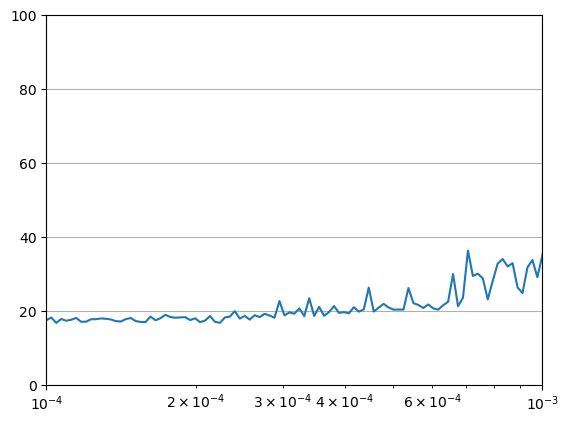

In [341]:
plt.semilogx(lr_rates, hist.history['loss'])
plt.grid(True)
plt.axis([1e-4, 1e-3, 0, 100])
plt.show()

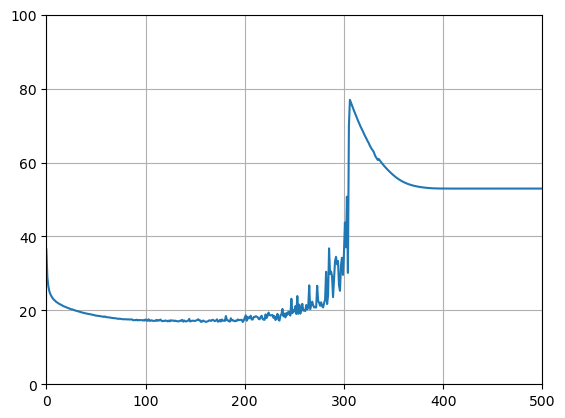

In [342]:
plt.plot(hist.history['mae'])
plt.axis([0, EPOCHS, 0, 100])
plt.grid(True)
plt.show()

## Best Model

In [343]:
class optimum_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['val_loss'] < 16.5:
            print(f'\nStop Training at {epoch}')
            self.model.stop_training = True

stop_training = optimum_callback()

In [344]:
model2 = create_model()
model2.compile(
    optimizer=SGD(learning_rate=best_lr, momentum=0.9),
    loss=Huber(),
    metrics=['mae']
)

In [345]:
hist2 = model2.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[stop_training])

Epoch 1/500
84/84 [==============================] - 0s 2ms/step - loss: 29.9522 - mae: 30.4468 - val_loss: 19.5757 - val_mae: 20.0667
Epoch 2/500
84/84 [==============================] - 0s 876us/step - loss: 19.2629 - mae: 19.7545 - val_loss: 18.9244 - val_mae: 19.4165
Epoch 3/500
84/84 [==============================] - 0s 904us/step - loss: 19.2197 - mae: 19.7138 - val_loss: 21.2612 - val_mae: 21.7518
Epoch 4/500
84/84 [==============================] - 0s 883us/step - loss: 19.8682 - mae: 20.3610 - val_loss: 19.5578 - val_mae: 20.0446
Epoch 5/500
84/84 [==============================] - 0s 881us/step - loss: 18.7453 - mae: 19.2369 - val_loss: 20.8731 - val_mae: 21.3648
Epoch 6/500
84/84 [==============================] - 0s 853us/step - loss: 18.9343 - mae: 19.4257 - val_loss: 17.5486 - val_mae: 18.0394
Epoch 7/500
84/84 [==============================] - 0s 884us/step - loss: 17.9471 - mae: 18.4409 - val_loss: 17.3597 - val_mae: 17.8494
Epoch 8/500
84/84 [========================

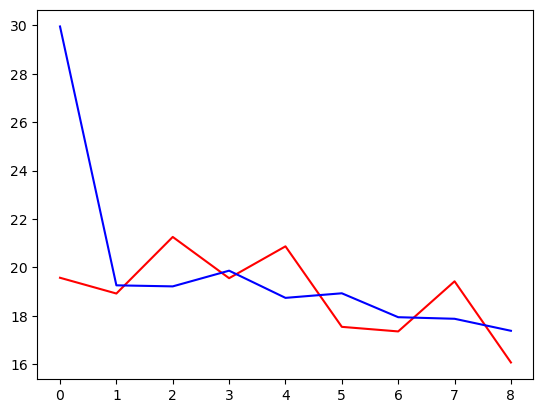

In [346]:
plt.plot(hist2.history['val_loss'],'r')
plt.plot(hist2.history['loss'],'b')

## Forecast

In [347]:
signal = series[SPLIT_SIZE-WINDOW_SIZE:-1]
forecast = create_dataset(signal, WINDOW_SIZE, True)

prediction = model2.predict(forecast)
prediction = prediction.squeeze()

18/18 [==============================] - 0s 2ms/step


In [348]:
print(prediction.shape)

(565,)


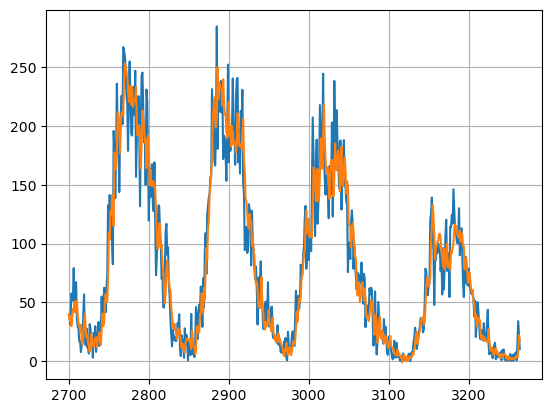

In [349]:
multi_plot_graph(val_time, (val_data, prediction))
# plot_graph(val_time, prediction)

In [350]:
print(tf.keras.metrics.mean_absolute_error(val_data, prediction).numpy())
print(tf.keras.metrics.mean_squared_error(val_data, prediction).numpy())

16.353403
522.9282


## Exponential Decay
This allows us to dynamically reduce the learning rate while training itself.

In [371]:
model3 = tf.keras.Sequential([
    Conv1D(
        filters=64,
        kernel_size=3,
        padding='causal',
        strides=1,
        activation='relu',
        input_shape=(WINDOW_SIZE, 1)
    ),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
    Lambda(lambda y: y * 400)
])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 30, 64)            256       
                                                                 
 bidirectional_4 (Bidirecti  (None, 30, 128)           66048     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 30)                3870      
                                                                 
 dense_8 (Dense)             (None, 10)                310       
                                                                 
 dense_9 (Dense)             (None, 1)                

In [372]:
expo_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-7,
    decay_rate=0.95,
    decay_steps=400,
    staircase=True
)

In [373]:
model3.compile(
    optimizer=SGD(learning_rate=expo_scheduler, momentum=0.9),
    loss=Huber(),
    metrics=['mae']
)

In [374]:
hist3 = model3.fit(train_set, epochs = 100)

Epoch 1/100
84/84 [==============================] - 5s 18ms/step - loss: 30.3479 - mae: 30.8435
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 25.5001 - mae: 25.9956
Epoch 3/100
84/84 [==============================] - 2s 20ms/step - loss: 24.4258 - mae: 24.9206
Epoch 4/100
84/84 [==============================] - 2s 19ms/step - loss: 23.7084 - mae: 24.2033
Epoch 5/100
84/84 [==============================] - 2s 18ms/step - loss: 23.1120 - mae: 23.6066
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 22.5749 - mae: 23.0693
Epoch 7/100
84/84 [==============================] - 2s 19ms/step - loss: 21.9920 - mae: 22.4860
Epoch 8/100
84/84 [==============================] - 2s 19ms/step - loss: 21.7530 - mae: 22.2454
Epoch 9/100
84/84 [==============================] - 2s 19ms/step - loss: 21.3618 - mae: 21.8563
Epoch 10/100
84/84 [==============================] - 2s 19ms/step - loss: 21.2398 - mae: 21.7344
Epoch 11/100
84/84 [=========

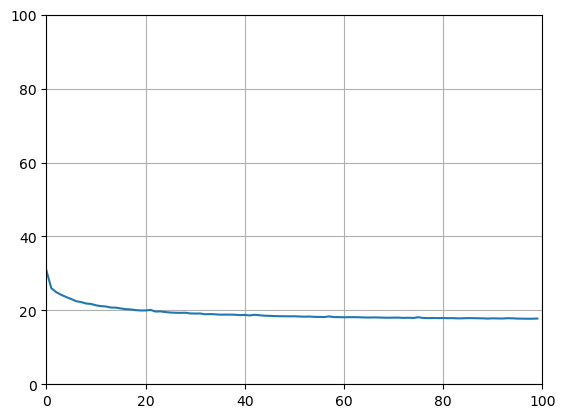

In [375]:
plt.plot(hist3.history['mae'])
plt.axis([0, 100, 0, 100])
plt.grid(True)
plt.show()

In [376]:
signal = series[SPLIT_SIZE-WINDOW_SIZE:-1]
forecast = create_dataset(signal, WINDOW_SIZE, True)

prediction = model3.predict(forecast)
prediction = prediction.squeeze()

18/18 [==============================] - 1s 7ms/step


In [377]:
print(prediction.shape)

(565,)


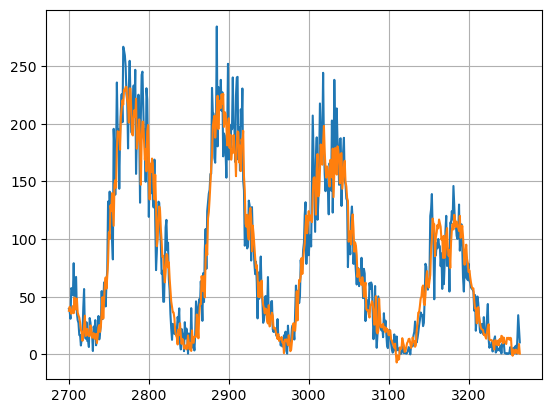

In [378]:
multi_plot_graph(val_time, (val_data, prediction))
# plot_graph(val_time, prediction)

In [379]:
print(tf.keras.metrics.mean_absolute_error(val_data, prediction).numpy())
print(tf.keras.metrics.mean_squared_error(val_data, prediction).numpy())

16.816902
516.0392
